In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí SARIMA modelu

*Zdroj dat: https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19*

Uvažujme opět datovou sadu poskytovanou MZ ČR s následujícím popisem:

```Datová sada obsahující kumulativní denní počty osob s prokázaným onemocněním COVID-19 dle hlášení krajských hygienických stanic včetně laboratoří, denní počty vyléčených po onemocnění COVID‑19 dle hlášení krajských hygienických stanic, denní počty úmrtí v souvislosti s onemocněním COVID‑19 dle hlášení krajských hygienických stanic a hospitalizačních úmrtí, a denní počty provedených testů na onemocnění COVID-19 dle hlášení laboratoří. S ohledem na fakt, že vykazování vyléčených osob a úmrtí má určité zpoždění oproti reálnému stavu z důvodu validace a uzavírání případů krajských hygienických stanic, se mohou denní záznamy zpětně měnit právě z důvodu průběžného doplňování.```

Jelikož poskytovatel nedává schema CSV k první verzi automaticky, budeme si muset data (opět) sami prozkoumat :)

In [56]:
fn = 'https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True, infer_datetime_format=True)
data.head()

,kumulovany_pocet_nakazenych,kumulovany_pocet_vylecenych,kumulovany_pocet_umrti,kumulovany_pocet_provedenych_testu,kumulovany_pocet_provedenych_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu
datum,,,,,,,,,,
2020-01-27,0,0,0,20,0,0,0,0,20,0
2020-01-28,0,0,0,28,0,0,0,0,8,0
2020-01-29,0,0,0,33,0,0,0,0,5,0
2020-01-30,0,0,0,34,0,0,0,0,1,0
2020-01-31,0,0,0,37,0,0,0,0,3,0


Zaměříme se na přírůstkový počet provedených antigenních testů v několika posledních týdnech. Mají data nějaké význačné vlastnosti?

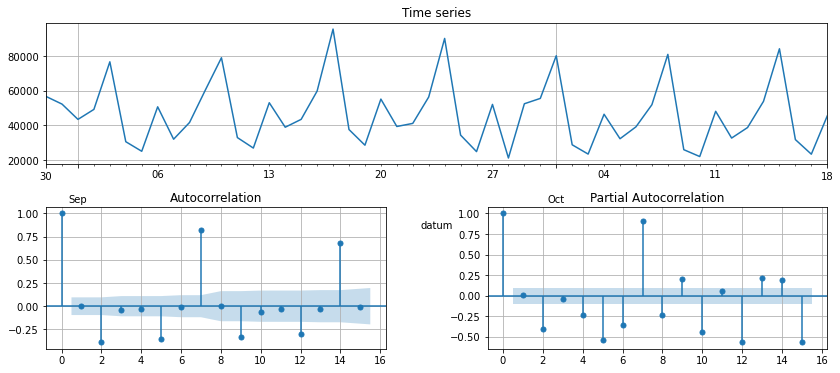

In [89]:
df_analysis = data['prirustkovy_pocet_provedenych_ag_testu'].last('8W')
df_analysis = df_analysis.asfreq('D')

tsplot(df_analysis, lags=15)

Zřejmě bychom mohli zkusit zapracovat na trendu v sezónních datech...

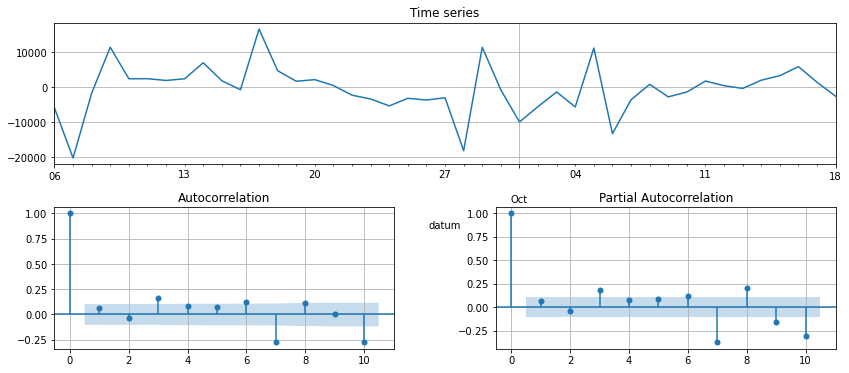

In [90]:
df_analysis_d7 = df_analysis.diff(7).dropna()
tsplot(df_analysis_d7, lags=10)

Sezónnost se podařilo trochu utlumit, zajímalo by nás, zda by šlo utlumit obecný trend:

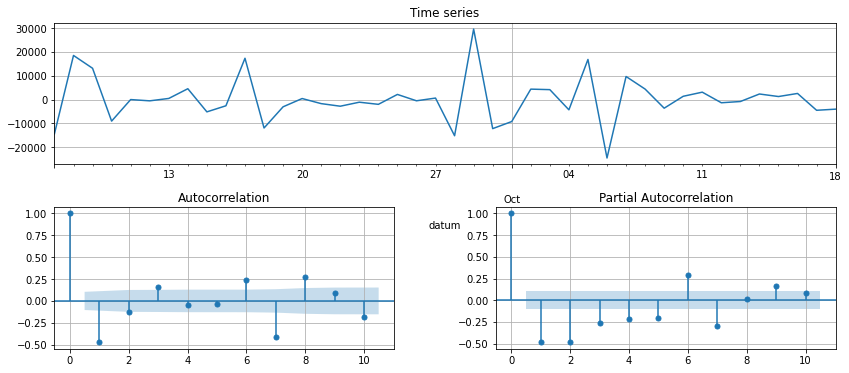

In [91]:
df_analysis_d7_d1 = df_analysis_d7.diff().dropna()
tsplot(df_analysis_d7_d1, lags=10)

Jakousi představu bychom měli, můžeme se podívat, jak bude korespondovat s automatizovaným odhadem řádů SARIMA modelu.

### Odhad řádů pomocí `pmdarima`

Odhad řádů (p,d,q) a (P,D,Q)s jde rovněž provádět pomocí [`pmdarima`](https://alkaline-ml.com/pmdarima/index.html), konkrétně metodou `auto_arima()`. Parametr `stepwise` umožňuje řídit, jak moc se bude hledání řádů "optimalizovat", či zda poběží na síti všech kombinací.

In [112]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(df_analysis, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, trace=True, stepwise=False,
                             information_criterion='bic')

 ARIMA(0,1,0)(0,1,0)[7]             : BIC=892.260, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[7]             : BIC=890.617, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[7]             : BIC=894.268, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[7]             : BIC=891.323, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[7]             : BIC=894.396, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[7]             : BIC=897.978, Time=0.33 sec
 ARIMA(0,1,0)(2,1,0)[7]             : BIC=901.165, Time=0.14 sec
 ARIMA(0,1,0)(2,1,1)[7]             : BIC=903.518, Time=0.26 sec
 ARIMA(0,1,0)(2,1,2)[7]             : BIC=900.190, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[7]             : BIC=896.265, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=893.521, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[7]             : BIC=896.614, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[7]             : BIC=887.918, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[7]             : BIC=896.894, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[7]             : BIC=900.317, Time=0.18 sec
 ARIMA(0,1,1)(2,1,0)[7]  

Automatickým nástrojem máme vybraný nejlepší model. Ten můžeme následně nafitovat pomocí `ARIMA()`. `pmdarima` umožňuje pokračovat s ní, ale pro přímočarost zůstaňme u `statsmodels`:

In [108]:
model = ARIMA(df_analysis, order=(0,1,1), seasonal_order=(1,1,0,7), trend='n')
res = model.fit()
print(res.summary())

                                         SARIMAX Results                                          
Dep. Variable:     prirustkovy_pocet_provedenych_ag_testu   No. Observations:                   50
Model:                       ARIMA(0, 1, 1)x(1, 1, [], 7)   Log Likelihood                -438.353
Date:                                    Wed, 20 Oct 2021   AIC                            882.705
Time:                                            11:41:43   BIC                            887.918
Sample:                                        08-30-2021   HQIC                           884.616
                                             - 10-18-2021                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4168      0.062     -6.708      0

Sami interpretujte výsledky! Ty výše, ale i ty níže...

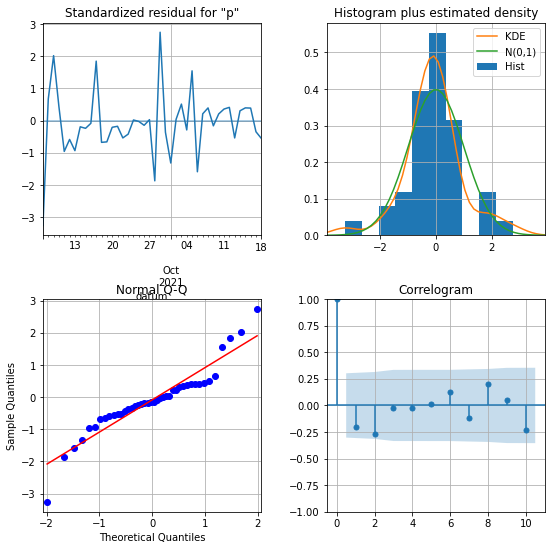

In [109]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

In [110]:
fcast_horizon = df_analysis.index[-1] + pd.Timedelta('3W')
preds = res.get_prediction(end=fcast_horizon)

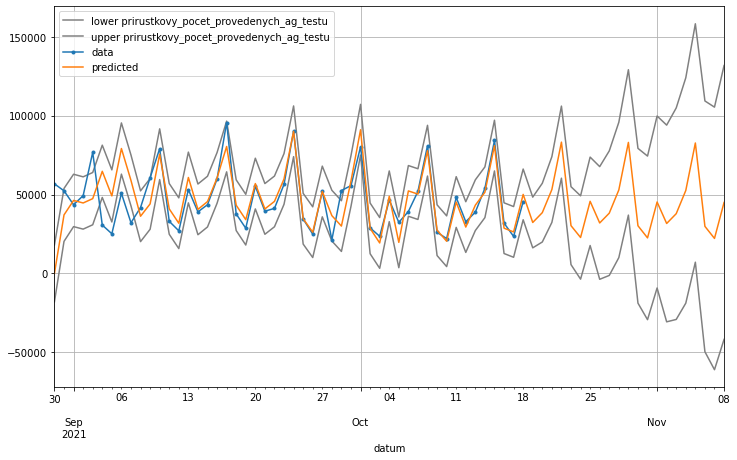

In [114]:
ci = preds.conf_int()

fig = ci.plot(color='grey', figsize=(12, 7))
res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predicted', fig=fig)
plt.legend()
plt.show()